## PSYC 179 Assignment 1
The below code goes through loading the Neuralynx data from an experiment recording dorsal hippocampus CA1 neurons. Ultimately, we make tuning curves of firing rates based on the rat's position.

Below are the packages that you will need if you wish to run this code yourself. Downloading Python 2.7 via [Anaconda] (https://www.continuum.io/downloads) gets you most of the useful scientific packages. But I believe [Shapely] (https://pypi.python.org/pypi/Shapely) is not included in that distribution.

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from shapely.geometry import Point, LineString
from scipy import signal
from IPython.display import Image

Let's import the raw data over from Neuralynx (via Matlab as there is currently no good Neuralynx to Python loading functions). A good (but hard!) next step would be to impletment these loading features. A place to start would be the Neo repository <https://github.com/NeuralEnsemble/python-neo>.

In [17]:
def load_csc(matfile):
    loading_csc = sio.loadmat(matfile)
    csc = dict(time=[])
    csc['data'] = loading_csc['csc_data'][0]
    for val in range(len(loading_csc['csc_tvec'])):
        csc['time'].append(loading_csc['csc_tvec'][val][0])
    csc['type'] = loading_csc['csc_type'][0]
    csc['label'] = loading_csc['csc_label'][0][0][0]
    return csc


def load_position(matfile):
    loading_pos = sio.loadmat(matfile)
    pos = dict()
    pos['x'] = loading_pos['pos_datax'][0]
    pos['y'] = loading_pos['pos_datay'][0]
    pos['time'] = loading_pos['pos_tvec'][0]
    pos['type'] = loading_pos['pos_type'][0]
    pos['label'] = loading_pos['pos_label'][0][0][0]
    return pos


# This data had issues with the feeder lights contaminating the position tracking, so those contaminating signals were removed.
def load_videotrack(matfile):
    loading_vt = sio.loadmat(matfile)
    vt = dict()
    vt['time'] = loading_vt['pos_tsd'][0][0][0][0]
    vt['x'] = loading_vt['pos_tsd'][0][0][1][0]
    vt['y'] = loading_vt['pos_tsd'][0][0][1][1]

    nan_idx = np.isnan(vt['x']) | np.isnan(vt['y'])
    vt['time'] = vt['time'][~nan_idx]
    vt['x'] = vt['x'][~nan_idx]
    vt['y'] = vt['y'][~nan_idx]
    return vt


def load_events(matfile):
    loading_events = sio.loadmat(matfile)
    events = dict()
    events['led1'] = loading_events['evt_led1id'][0]
    events['led2'] = loading_events['evt_led2id'][0]
    events['ledoff'] = loading_events['evt_ledoff'][0]
    events['pb1'] = loading_events['evt_pb1id'][0]
    events['pb2'] = loading_events['evt_pb2id'][0]
    events['pboff'] = loading_events['evt_pboff'][0]
    events['feeder1'] = loading_events['evt_feeder1id'][0]
    events['feeder2'] = loading_events['evt_feeder2id'][0]
    events['feederoff'] = loading_events['evt_feederoff'][0]
    events['type'] = loading_events['evt_type'][0]
    events['label'] = loading_events['evt_label'][0][0][0]
    return events


def load_spikes(matfile):
    loading_spikes = sio.loadmat(matfile)
    spikes = dict()
    spikes['time'] = loading_spikes['spikes_times'][0]
    spikes['type'] = loading_spikes['spikes_type'][0]
    spikes['label'] = loading_spikes['spikes_label'][0][0][0]
    return spikes

The experiment specific information should ideally be stored elsewhere and imported here. But for now, this works!

In [18]:
# Experimental session-specific task times for R063 day 2
task_times = dict()
task_times['prerecord'] = [721.9412, 1027.1]
task_times['phase1'] = [1075.8, 1569.6]
task_times['pauseA'] = [1593.9, 2219.0]
task_times['phase2'] = [2243.4, 3512.4]
task_times['pauseB'] = [3556.1, 5441.3]
task_times['phase3'] = [5469.7, 8794.6]
task_times['postrecord'] = [8812.7, 9143.4]

t_start = task_times['phase2'][0]
t_stop = task_times['phase2'][1]

# Session-specific path trajectory points
path_pts = dict()
path_pts['feeder1'] = (468, 471)
path_pts['point1'] = (466, 397)
path_pts['turn1'] = (465, 380)
path_pts['point2'] = (445, 380)
path_pts['point3'] = (298, 398)
path_pts['point4'] = (173, 367)
path_pts['turn2'] = (148, 359)
path_pts['point5'] = (138, 319)
path_pts['point6'] = (140, 103)
path_pts['turn3'] = (155, 69)
path_pts['point7'] = (203, 58)
path_pts['feeder2'] = (661, 54)
path_pts['shortcut1'] = (467, 378)
path_pts['point8'] = (466, 195)
path_pts['point9'] = (496, 166)
path_pts['point10'] = (645, 164)
path_pts['point11'] = (669, 162)
path_pts['point12'] = (672, 146)
path_pts['shortcut2'] = (661, 55)
path_pts['novel1'] = (146, 359)
path_pts['novel2'] = (49, 351)

Loading the data takes some time, it's better to do all at once then not again!

In [19]:
# Load the data
csc = load_csc('emi_inputs_csc.mat')
pos = load_videotrack('emi_inputs_vt.mat')
events = load_events('emi_inputs_event.mat')
spikes = load_spikes('emi_inputs_spike.mat')

Now that we have the data let's plot it to make sure it looks as we expect and it's in data formats that we can use!

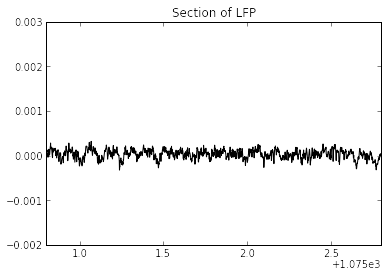

In [20]:
# Plotting lfp
plt.plot(csc['time'], csc['data'], 'k')
plt.xlim(1075.8, 1077.8)
plt.title('Section of LFP')
plt.show()

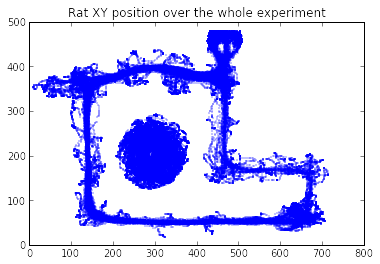

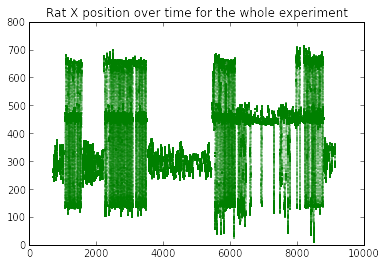

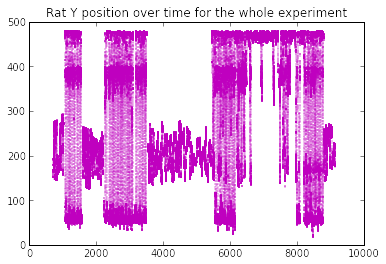

In [21]:
# Plotting position x-y and x-by-time
plt.plot(pos['x'], pos['y'], 'b.', ms=1)
plt.title('Rat XY position over the whole experiment')
plt.show()
plt.plot(pos['time'], pos['x'], 'g.', ms=1)
plt.title('Rat X position over time for the whole experiment')
plt.show()
plt.plot(pos['time'], pos['y'], 'm.', ms=1)
plt.title('Rat Y position over time for the whole experiment')
plt.show()

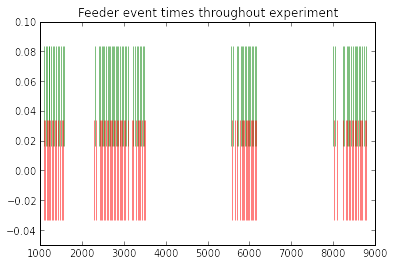

In [22]:
# Plotting feeder event times
plt.plot(events['feeder1'], np.zeros(len(events['feeder1']))+0.05, '|', color='g', ms=100)
plt.plot(events['feeder2'], np.zeros(len(events['feeder2'])), '|', color='r', ms=100)
plt.ylim(-0.05, 0.1)
plt.title('Feeder event times throughout experiment')
plt.show()

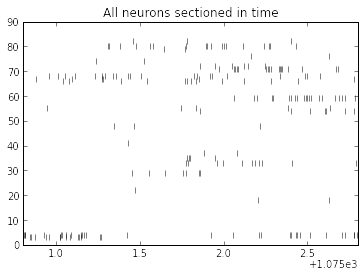

In [23]:
# Plotting spike times
for neuron in range(len(spikes['time'])):
    plt.plot(spikes['time'][neuron], np.ones(len(spikes['time'][neuron]))+neuron+1, '|', color='k')
plt.xlim(1075.8, 1077.8)
plt.title('All neurons sectioned in time')
plt.show()

# Analyses using the data

Now that we have the data in a format that we can work with an visualize, let's see how we can manipulate it to better understand the kinds of things that we're interested in with this type of data!

In [24]:
# Some useful functions
def find_nearest_idx(array, val):
    return (np.abs(array-val)).argmin()


def time_slice(spikes, t_start, t_stop):
    if t_start is None:
        t_start = -np.inf
    if t_stop is None:
        t_stop = np.inf
    indices = (spikes >= t_start) & (spikes <= t_stop)
    sliced_spikes = spikes[indices]
    return sliced_spikes


def linear_trajectory(pos, ideal_path, trial_start, trial_stop):
    t_start_idx = find_nearest_idx(np.array(pos['time']), trial_start)
    t_end_idx = find_nearest_idx(np.array(pos['time']), trial_stop)

    pos_trial = dict()
    pos_trial['x'] = pos['x'][t_start_idx:t_end_idx]
    pos_trial['y'] = pos['y'][t_start_idx:t_end_idx]
    pos_trial['time'] = pos['time'][t_start_idx:t_end_idx]
    
    z = dict(position=[])
    z['time'] = pos_trial['time']
    for point in range(len(pos_trial['x'])):
        position = Point(pos_trial['x'][point], pos_trial['y'][point])
        # linearized_point = ideal_path.interpolate(ideal_path.project(position))
        # linear_pos['x'].append(linearized_point.xy[0])
        # linear_pos['y'].append(linearized_point.xy[1])
        z['position'].append(ideal_path.project(position))
    return z
    
    
def raster_plot(spikes, colour='k'):
    for neuron in range(len(spikes)):
        plt.plot(spikes[neuron], np.ones(len(spikes[neuron]))+neuron+1, 
                 '|', color=colour)

An important first step is to restrict the data times -- in other words take a time slice of the data. The same time slice should be applied to spikes, LFP, and position.

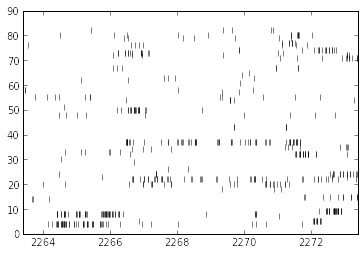

In [25]:
# Slicing spikes
sliced_spikes = dict(time=[])
for neuron in range(len(spikes['time'])):
    sliced_spikes['time'].append(time_slice(spikes['time'][neuron], t_start, t_stop))
assert len(sliced_spikes['time']) == len(spikes['time'])
raster_plot(sliced_spikes['time'])
plt.xlim(t_start+20, t_start+30)
plt.show()

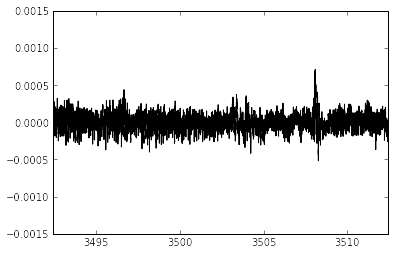

In [26]:
# Slicing LFPs
t_start_idx = find_nearest_idx(np.array(csc['time']), t_start)
t_end_idx = find_nearest_idx(np.array(csc['time']), t_stop)

sliced_csc = dict()
sliced_csc['data'] = csc['data'][t_start_idx:t_end_idx] # Make this into a function to prevent mistakes
sliced_csc['time'] = csc['time'][t_start_idx:t_end_idx]

plt.plot(sliced_csc['time'], sliced_csc['data'], 'k')
plt.xlim(t_stop-20, t_stop)
plt.show()

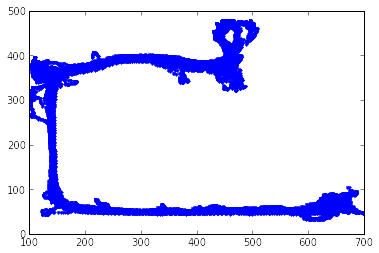

In [27]:
# Slicing position
t_start_idx = find_nearest_idx(np.array(pos['time']), t_start)
t_end_idx = find_nearest_idx(np.array(pos['time']), t_stop)

sliced_pos = dict()
sliced_pos['x'] = pos['x'][t_start_idx:t_end_idx]
sliced_pos['y'] = pos['y'][t_start_idx:t_end_idx]
sliced_pos['time'] = pos['time'][t_start_idx:t_end_idx]

plt.plot(sliced_pos['x'], sliced_pos['y'], 'b.')
plt.show()

Great! So, we can slice any data type in time. Having the position as 2D makes most of the analyses harder, instead let's make it 1D by taking an ideal linear trajectory and projecting ('snapping') the actual rat's position to that trajectory.

## Tuning curves
For our purposes we are interested in the firing rate of the neurons by position of the rat. But in theory this code could be used to evaluate the firing rate by other variables as well. Below is the basic tuning curve function where we determing firing rate based on the rat's position for each neuron.

In [28]:
def tuning_curve(position_z, spike_times, num_bins=100, sampling_rate=1/30.0):
    linear_start = np.min(position_z['position'])
    linear_stop = np.max(position_z['position'])
    binned_spikes = np.zeros(num_bins)
    bin_edges = np.linspace(linear_start, linear_stop, num=num_bins)
    bin_centers = np.array((bin_edges[1:] + bin_edges[:-1]) / 2.)
    tc = []
    occupancy = np.zeros(len(bin_centers))
    for pos in position_z['position']:
        pos_idx = find_nearest_idx(bin_centers, pos)
        occupancy[pos_idx] += sampling_rate
    occupied_idx = occupancy > 0
    for neuron in range(len(spike_times)):
        spike_z = np.zeros(len(bin_centers))
        for spike_time in spike_times[neuron][0]:
            assigned_bin = find_nearest_idx(np.array(position_z['time']), spike_time)
            which_bin = find_nearest_idx(bin_centers, position_z['position'][assigned_bin])
            spike_z[which_bin] += 1
        firing_rate = np.zeros(len(bin_centers))
        firing_rate[occupied_idx] = spike_z[occupied_idx] / occupancy[occupied_idx]
        tc.append(firing_rate)
    return tc

We commonly convolve the firing rate with a normalized Gaussian. Here I kept the code separate, but it may be better to add it in the general tuning curve function because it is so ubiquitous in our analyses.

In [29]:
def filter_tc(tuning_curve, filter_type='gaussian', gaussian_std=3.):
    if filter_type == 'gaussian':
        gauss_tc = []
        # Normalizing gaussian filter
        gaussian_filter = signal.get_window(('gaussian', gaussian_std), gaussian_std*6.)
        normalized_gaussian = gaussian_filter / np.sum(gaussian_filter)
        for firing_rate in tuning_curve:
            gauss_tc.append(np.convolve(firing_rate, normalized_gaussian, mode='same'))
        return gauss_tc

Here I define the ideal trajectories that I project onto to make the 1D linear position.

In [30]:
u_line = LineString([path_pts['feeder1'], path_pts['point1'], path_pts['turn1'], 
                     path_pts['point2'], path_pts['point3'], path_pts['point4'], 
                     path_pts['turn2'], path_pts['point5'], path_pts['point6'], 
                     path_pts['turn3'], path_pts['point7'], path_pts['feeder2']])

shortcut_line = LineString([path_pts['shortcut1'], path_pts['point8'], path_pts['point9'], 
                            path_pts['point10'], path_pts['point11'], path_pts['point12'], 
                            path_pts['shortcut2']])

novel_line = LineString([path_pts['novel1'], path_pts['novel2']])

In [31]:
linear_u = linear_trajectory(pos, u_line, t_start, t_stop)

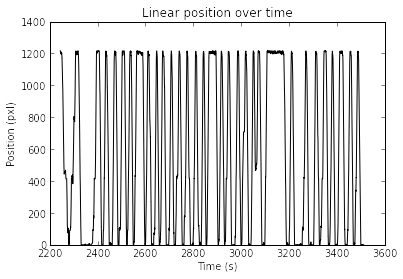

In [46]:
plt.plot(linear_u['time'], linear_u['position'], 'k')
plt.title('Linear position over time')
plt.ylabel('Position (pxl)')
plt.xlabel('Time (s)')
plt.show()

Below I make up some fake data to run it through my tuning curve and filtered tuning curve functions to ensure that they are working as anticipated. Here I specify three neurons that spike 1-2 times each. I specify three positions that the rat encounters during this fake session, at the ends and middle of the linear trajectory, as determined from the real data for easier comparasion purposes.

In [33]:
toy_spike_times = [[np.array([0.21, 0.31])], [np.array([0.1, 0.11])], [np.array([0.38])]]
toy_linear = dict(position=[], time=[])
min_position = np.min(linear_u['position'])
max_position = np.max(linear_u['position'])
position_center = (max_position + min_position) / 2.0
toy_linear['position'] = [min_position, position_center, position_center, max_position]
toy_linear['time'] = [0.11, 0.21, 0.31, 0.41]
toy_tc = tuning_curve(toy_linear, toy_spike_times, num_bins=50)

What we're expecting to see is the first neuron with a maximum peak in the middle and a firing rate equal to the last neuron (which has a peak at the end position) because it fired twice and the rat was in that position twice. The second neuron has double the firing rate (it spikes twice and the rat was in that position once) compared to the other two and fires maximally at the start position. The last neuron only spikes once and the rat is in that location for one timestep, so its rate is the same as the first neuron.

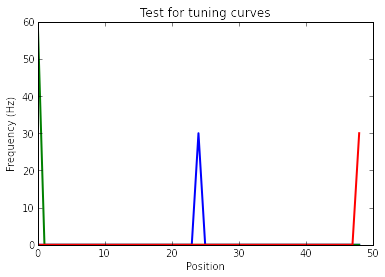

In [34]:
for tc in toy_tc:
    plt.plot(tc, lw=2)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Position')
plt.title('Test for tuning curves')
plt.show()

In [35]:
toy_filtered_tc = filter_tc(toy_tc)

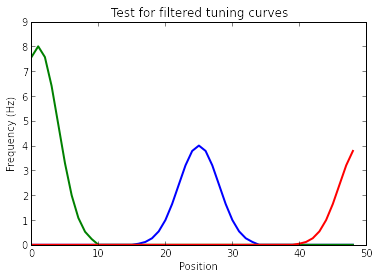

In [36]:
for filtered_tc in toy_filtered_tc:
    plt.plot(filtered_tc, lw=2)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Position')
plt.title('Test for filtered tuning curves')
plt.show()

That looks about right! Let's try it using real data from only Phase 2 of the shortcut experiment. During this phase the rat is restricted to only running along the "U" track segment, so that's the only portion that we need to have linear.

Let's slice the time for the neuron spikes to only Phase 2.

In [37]:
phase_spikes = dict(time=[])
for neuron in range(len(spikes['time'])):
        phase_spikes['time'].append(time_slice(spikes['time'][neuron], t_start, t_stop))
assert len(phase_spikes['time']) == len(spikes['time'])

Typically, it's also important to filter our spikes based on expected frequencies to eliminate noise or overly active interneurons because here we're interested in Place Cells.

In [38]:
sampling_rate = 1 / 30.0
filtering = 4
min_spikes = 100
max_spikes = len(linear_u['time']) * sampling_rate * filtering
filtered_freq_spikes = dict(time=[])
for neuron in range(len(phase_spikes['time'])):
    if (len(phase_spikes['time'][neuron]) > min_spikes) and (len(phase_spikes['time'][neuron]) <= max_spikes):
        filtered_freq_spikes['time'].append([phase_spikes['time'][neuron]])

Below is where we actually call the tuning curve function, then plot it to see what it looks like.

In [39]:
tc = tuning_curve(linear_u, filtered_freq_spikes['time'], num_bins=47)

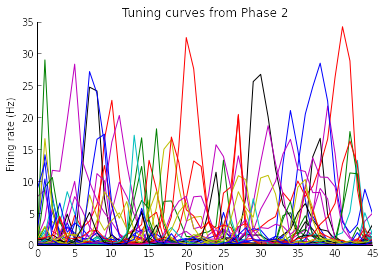

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
for curve in tc:
    ax.plot(curve)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Position')
plt.title('Tuning curves from Phase 2')
plt.show()

In [42]:
filtered_tc = filter_tc(tc)

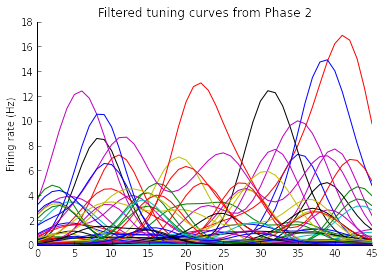

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
for curve in filtered_tc:
    ax.plot(curve)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Position')
plt.title('Filtered tuning curves from Phase 2')
plt.show()

Okay, that does something! Now we can use these tuning curves to determine place cells, order neurons along positions and more!

Directly comparing to the output from Matlab, we see that the outputs are identical.

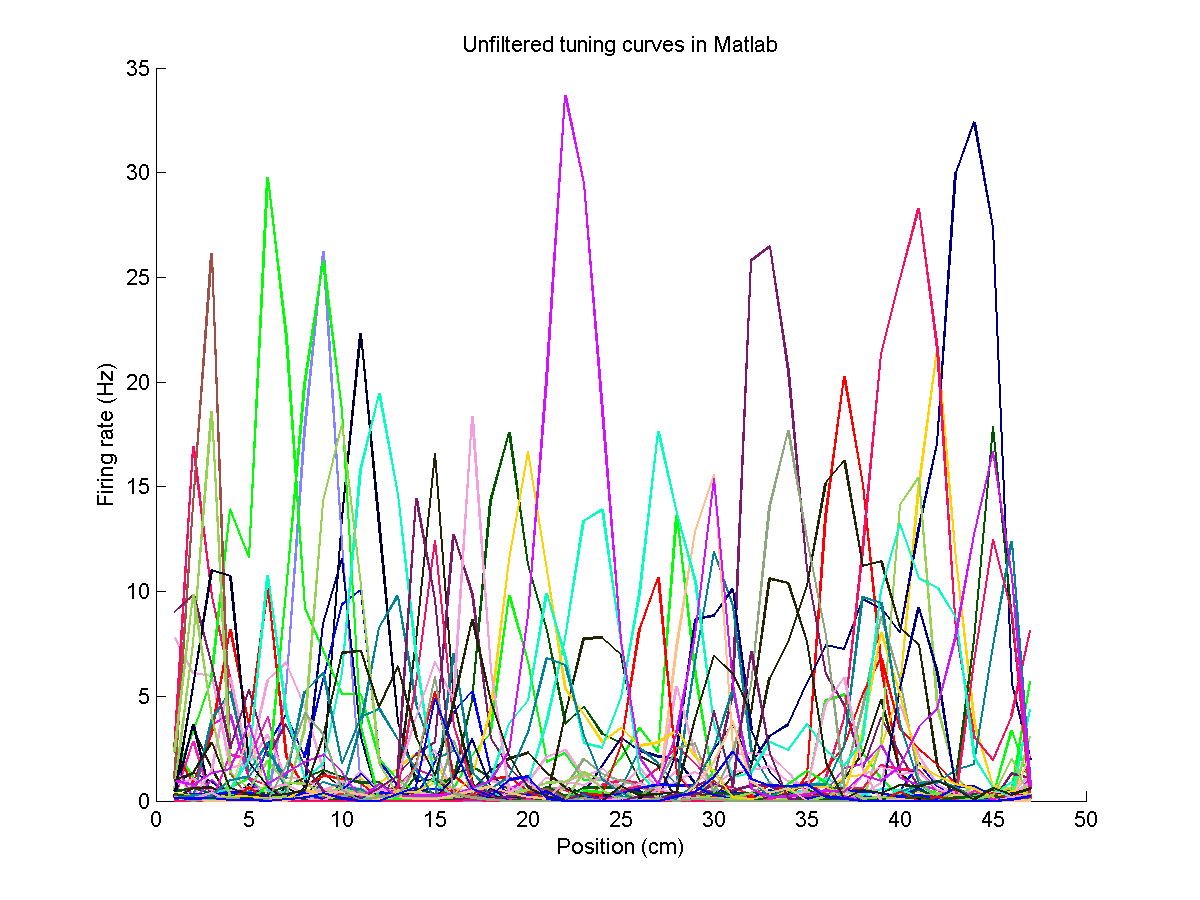

In [41]:
Image(filename = "matlab_unfiltered_tc.png")

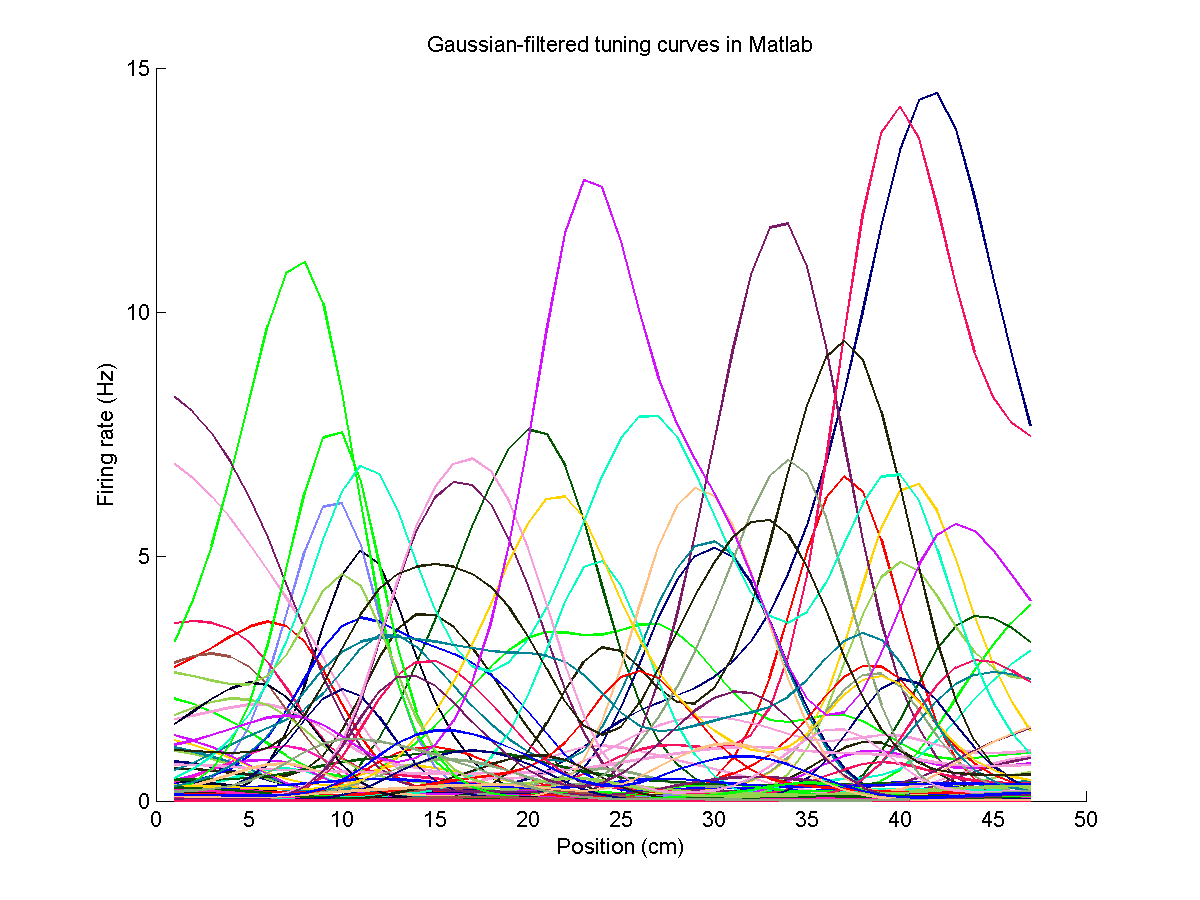

In [44]:
Image(filename = "matlab_filtered_tc.png")